<a href="https://colab.research.google.com/github/allielabrecque4-debug/Machine-Learning-Labrecque/blob/main/Machine_Learning_Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning Homework 4 <br>
Allie Labrecque <br>
662017931

In [1]:
# PROBLEM 1
# Construct a fully connected neural network model for classifying the CIFAR-10 dataset. Use a 70%-30% split for training and validation data
from tensorflow.keras.datasets import cifar10
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from keras import applications
import numpy as np
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the image data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


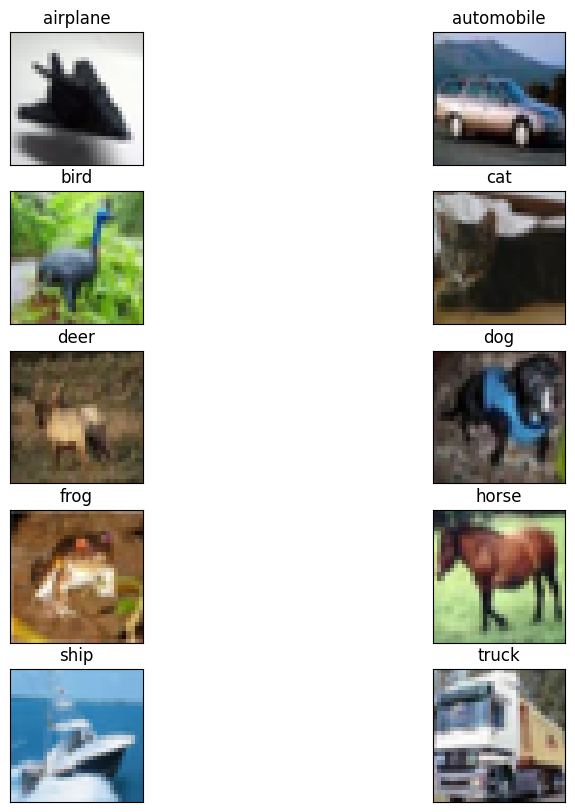

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot an image from each category
plt.figure(figsize=(10, 10))
for i in range(10):
    # Find the index of the first image belonging to the current class
    idx = np.where(y_train == i)[0][0]
    plt.subplot(5, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[idx], cmap=plt.cm.binary)
    plt.title(class_names[i])
plt.show()

In [2]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)

In [7]:
!pip install scikeras

In [3]:
from sklearn.model_selection import train_test_split

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

print("Shape of x_train_split:", x_train_split.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_train_split:", y_train_split.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train_split: (35000, 32, 32, 3)
Shape of x_val: (15000, 32, 32, 3)
Shape of y_train_split: (35000, 10)
Shape of y_val: (15000, 10)


In [14]:
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD

def build_classifier(optimizer='adam', learning_rate=0.001, units=64):
    """
    Builds a Keras Sequential model for CIFAR-10 classification.

    Args:
        optimizer (str): The optimizer to use ('adam' or 'sgd').
        learning_rate (float): The learning rate for the optimizer.
        units (int): The number of units in the dense layers.

    Returns:
        keras.Sequential: The compiled Keras model.
    """
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))  # Flatten the input image
    model.add(Dense(units, activation='relu'))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(10, activation='softmax')) # Output layer for 10 classes

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create an instance of KerasClassifier
keras_classifier = KerasClassifier(build_fn=build_classifier, verbose=0)

In [22]:
param_grid = {
    'build_fn__optimizer': ['adam', 'sgd'],
    'build_fn__learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [10, 20, 30]
}

In [24]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.7 MB/s eta 0:00:00


In [27]:
import os
import shutil

# Define the directory name
directory_name = 'my_dir'

# Check if the directory exists and remove it
if os.path.exists(directory_name):
    shutil.rmtree(directory_name)
    print(f"Removed existing directory: {directory_name}")
else:
    print(f"Directory does not exist: {directory_name}")

Removed existing directory: my_dir


In [28]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD

def build_classifier_kt(hp):
    """
    Builds a Keras Sequential model for CIFAR-10 classification using KerasTuner hyperparameters.

    Args:
        hp: KerasTuner HyperParameters object.

    Returns:
        keras.Sequential: The compiled Keras model.
    """
    model = Sequential()
    model.add(Flatten(input_shape=(32, 32, 3)))  # Flatten the input image
    model.add(Dense(units=hp.Choice('units', [32, 64, 128]), activation='relu'))
    model.add(Dense(units=hp.Choice('units', [32, 64, 128]), activation='relu'))
    model.add(Dense(10, activation='softmax')) # Output layer for 10 classes

    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd'])
    learning_rate_choice = hp.Choice('learning_rate', [0.001, 0.01, 0.1])

    if optimizer_choice == 'adam':
        opt = Adam(learning_rate=learning_rate_choice)
    elif optimizer_choice == 'sgd':
        opt = SGD(learning_rate=learning_rate_choice)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define the KerasTuner GridSearch tuner
tuner = kt.GridSearch(
    hypermodel=build_classifier_kt,
    objective='val_accuracy',
    directory='my_dir',
    project_name='cifar10_tuning'
)

# Define the search space based on your original param_grid
# Note: KerasTuner defines the search space within the hypermodel build function
# The grid values are specified using hp.Choice

# Perform the hyperparameter search
# Use x_train_split and y_train_split for training, and x_val and y_val for validation
tuner.search(x_train_split, y_train_split, epochs=10, validation_data=(x_val, y_val))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The best hyperparameters found are:
Optimizer: {best_hps.get('optimizer')}
Learning Rate: {best_hps.get('learning_rate')}
Units: {best_hps.get('units')}
""")

# Get the best model
best_model_kt = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
loss, accuracy = best_model_kt.evaluate(x_test, y_test, verbose=0)

# Print the evaluation results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Trial 18 Complete [00h 00m 41s]
val_accuracy: 0.42286667227745056

Best val_accuracy So Far: 0.4676666557788849
Total elapsed time: 00h 12m 34s

The best hyperparameters found are:
Optimizer: sgd
Learning Rate: 0.01
Units: 128

Test Loss: 1.4884
Test Accuracy: 0.4692


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


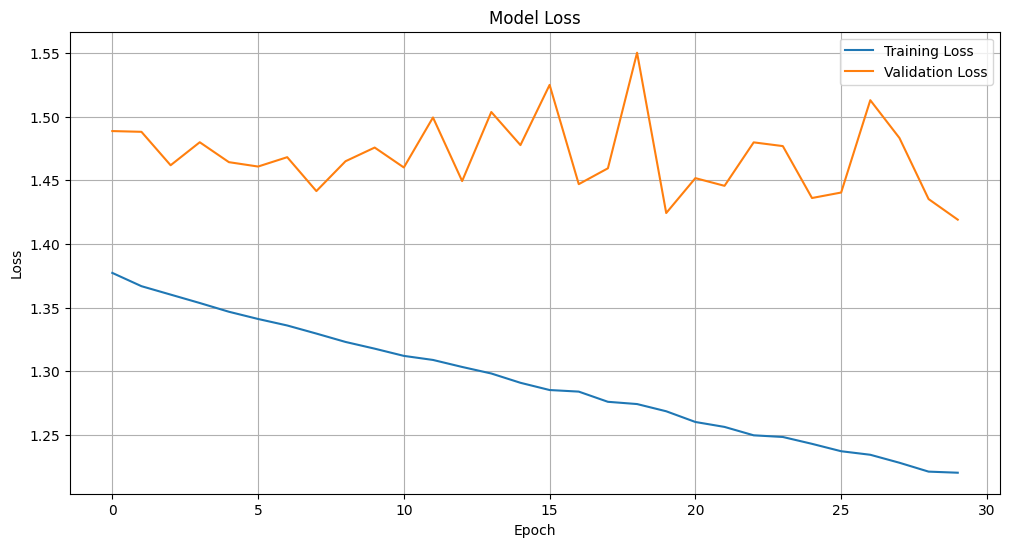

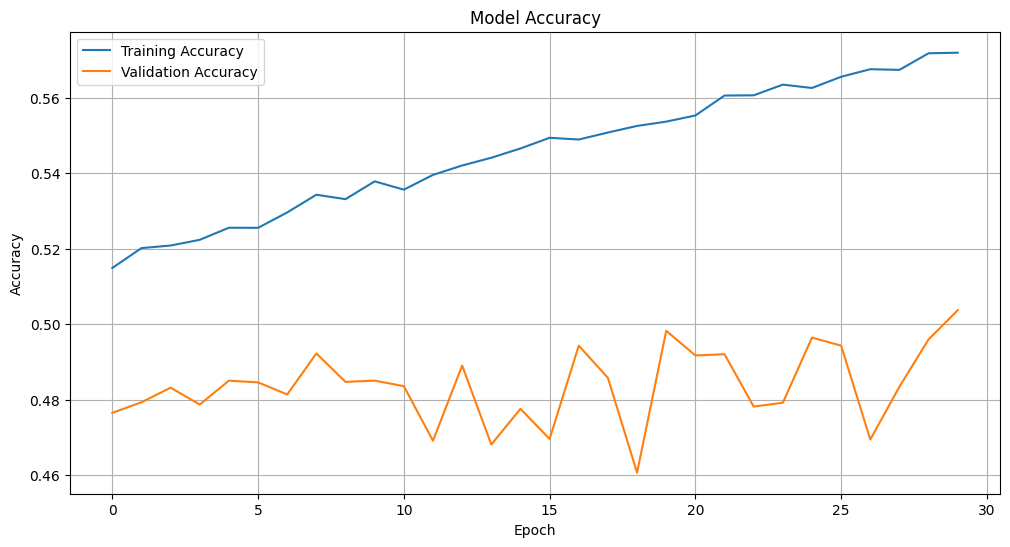

In [30]:
import matplotlib.pyplot as plt

# Get the best model from the tuner
best_model_for_plotting = tuner.get_best_models(num_models=1)[0]

# Train the best model and capture the history
history = best_model_for_plotting.fit(
    x_train_split,
    y_train_split,
    epochs=30, # Use a fixed number of epochs for plotting
    batch_size=128, # Use a fixed batch size for plotting
    validation_data=(x_val, y_val),
    verbose=0 # Set to 1 to see training progress
)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

PROBLEM 2

In [ ]:
# PROBLEM 2
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

csv_path= '/content/drive/MyDrive/NASAairfoil.csv'
test = pd.read_csv(csv_path)

features = test[['Frequency (Hz)', 'AOA (deg)','Chord Length (m)','Free-stream Velocity (m/s)','Suction side displacement thickness (m)']]
targets = test[['Scaled sound pressure level (decibel)']]


Mounted at /content/drive


In [15]:
# This import is sometimes needed to resolve compatibility issues between scikit-learn and scikeras
from sklearn.utils import all_estimators

In [18]:
from sklearn.model_selection import GridSearchCV

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3, n_jobs=-1)

# Fit GridSearchCV to the training data
grid_result = grid_search.fit(x_train_split, y_train_split)

# Print the best parameters and best score
print("Best parameters found: ", grid_result.best_params_)
print("Best cross-validation score: ", grid_result.best_score_)

# Get the best model from the grid search results
best_model = grid_result.best_estimator_

# Evaluate the best model on the test data
loss, accuracy = best_model.score(x_test, y_test) # Use score for scikeras

# Print the evaluation results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [17]:
# Get the best model from the grid search results
best_model = grid_result.best_estimator_

# Evaluate the best model on the test data
loss, accuracy = best_model.evaluate(x_test, y_test, verbose=0)

# Print the evaluation results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

NameError: name 'grid_result' is not defined

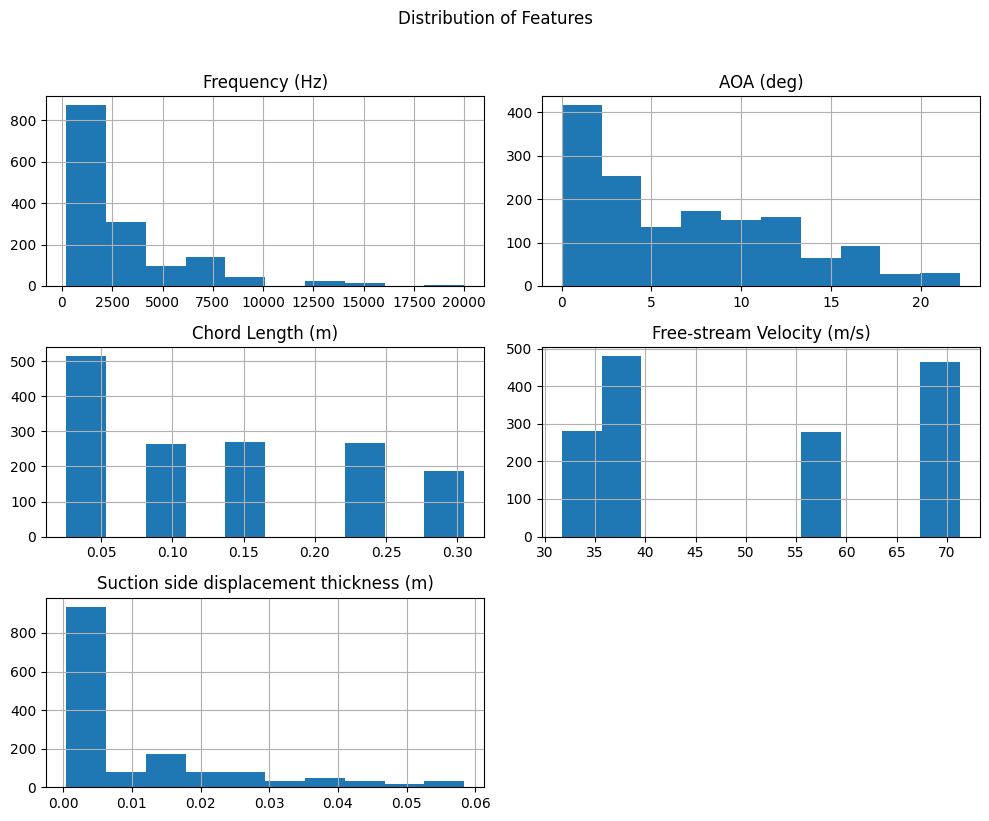

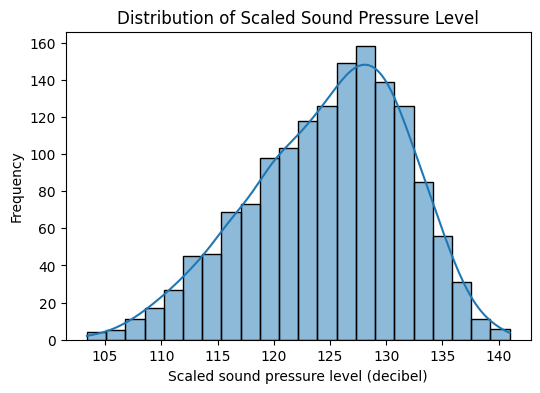

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of features
features.hist(figsize=(10, 8))
plt.suptitle('Distribution of Features', y=1.02)
plt.tight_layout()
plt.show()

# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.histplot(targets['Scaled sound pressure level (decibel)'], kde=True)
plt.title('Distribution of Scaled Sound Pressure Level')
plt.xlabel('Scaled sound pressure level (decibel)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [ ]:
# Construct a fully connected neural network model for estimating scaled sound pressure level, in decibels, from the attributes by choosing a 70%-30%
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer

# Split the data into training and validation sets (70%-30%)
X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.3, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu')) # Add another dense layer
model.add(Dense(64, activation='relu')) # Add another dense layer
model.add(Dense(64, activation='relu')) # Add another dense layer
model.add(Dense(64, activation='relu')) # Add another dense layer
model.add(Dense(64, activation='relu')) # Add another dense layer
model.add(Dense(1, activation='linear')) # Output layer for regression

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=200, batch_size=5, validation_data=(X_val_scaled, y_val))

# Evaluate the model on the validation set
loss, mae = model.evaluate(X_val_scaled, y_val, verbose=0)
print(f"Validation Loss (MSE): {loss:.4f}")
print(f"Validation MAE: {mae:.4f}")

model.summary()

Epoch 1/200


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 10238.0654 - mae: 90.0392 - val_loss: 341.5763 - val_mae: 14.7423
Epoch 2/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 321.3495 - mae: 14.3393 - val_loss: 187.0390 - val_mae: 10.9538
Epoch 3/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 178.6006 - mae: 10.8154 - val_loss: 126.6195 - val_mae: 9.2006
Epoch 4/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 101.3878 - mae: 8.0749 - val_loss: 63.8286 - val_mae: 6.3352
Epoch 5/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 58.9066 - mae: 6.1520 - val_loss: 43.0901 - val_mae: 4.9850
Epoch 6/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 37.3422 - mae: 4.7904 - val_loss: 23.9523 - val_mae: 3.7672
Epoch 7/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.1228 - mae: 3.8801 - val_loss: 19.9450 - val_mae: 3.3659
Epoch 8/200
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.0215 - mae: 3.6562 - val_loss: 19.3336 - val_mae: 3.3739
Epoch 9/200
211/211 ━━━━━━━━━

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_190 (Dense)               │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_194 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_195 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_196 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_197 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,229 (297.77 KB)

 Trainable params: 25,409 (99.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 50,820 (198.52 KB)

In [ ]:
from sklearn.metrics import r2_score

# Make predictions on the validation data
y_pred = model.predict(X_val_scaled)

# Calculate the coefficient of determination (R-squared)
r2 = r2_score(y_val, y_pred)

print(f"Coefficient of Determination (R-squared): {r2:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Coefficient of Determination (R-squared): 0.9377
